# Block Vectorization

## Downloads and Imports

In [1]:
import numpy as np
import csv
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import random
from sentence_transformers import SentenceTransformer

In [2]:
# Set seeds for determinism
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if hasattr(torch, 'use_deterministic_algorithms'):
    torch.use_deterministic_algorithms(True)


## Define blocks

In [3]:
# CHANGE THIS TO PERMANENT PATH
csv_file_path = "ordered_block_names.csv"

# Read the CSV file and store the column in a set
block_names = list()

with open(csv_file_path, mode='r') as file:
    reader = csv.reader(file)
    for row in reader:
        # Assuming the column you want is in the first column (index 0)
        block_names.append(row[0])

# Print the result
block_names = block_names[0:]
print(block_names)

['Air', 'Cave Air', 'Void Air', 'Cobblestone', 'Cobblestone Slab', 'Cobblestone Stairs', 'Cobblestone Wall', 'Infested Cobblestone', 'Mossy Cobblestone', 'Mossy Cobblestone Slab', 'Mossy Cobblestone Stairs', 'Mossy Cobblestone Wall', 'Stone', 'Stone Slab', 'Stone Stairs', 'Infested Stone', 'Smooth Stone', 'Smooth Stone Slab', 'Stone Bricks', 'Stone Brick Slab', 'Stone Brick Stairs', 'Stone Brick Wall', 'Infested Stone Bricks', 'Cracked Stone Bricks', 'Infested Cracked Stone Bricks', 'Chiseled Stone Bricks', 'Infested Chiseled Stone Bricks', 'Mossy Stone Bricks', 'Mossy Stone Brick Slab', 'Mossy Stone Brick Stair', 'Mossy Stone Brick Wall', 'Infested Mossy Stone Bricks', 'Stone Pressure Plate', 'Stone Button', 'Deepslate', 'Infested Deepslate', 'Cobbled Deepslate', 'Cobbled Deepslate Slab', 'Cobbled Deepslate Stairs', 'Cobbled Deepslate Wall', 'Polished Deepslate', 'Polished Deepslate Slab', 'Polished Deepslate Stairs', 'Polished Deepslate Wall', 'Deepslate Bricks', 'Deepslate Brick Sla

## Preprocess block names

In [4]:
# block_list = [block.lower().replace("_"," ") for block in block_names]

## Embeddings

### Using Proximity and an LLM

In [5]:
# # Generate order-based embeddings: normalized index as a single feature
# order_embeddings = np.array([[i / len(block_names)] for i in range(len(block_names))])

# # Generate semantic embeddings using an LLM (SentenceTransformer)
# model = SentenceTransformer('all-MiniLM-L6-v2')
# model.eval()
# semantic_embeddings = model.encode(block_names, convert_to_numpy=True, show_progress_bar=False)

# # Combine embeddings by concatenation
# combined_embeddings = np.hstack([order_embeddings, semantic_embeddings])

# # Dimensionality reduction with PCA to obtain a fixed-size latent vector
# latent_dim = 32
# pca = PCA(n_components=latent_dim)
# latent_vectors = pca.fit_transform(combined_embeddings)

# # Create a dictionary mapping block names to their latent vectors
# block_to_latent = {block_names[i]: latent_vectors[i] for i in range(len(block_names))}


### Using Proximity and TFIDF

In [6]:
# # Generate order-based embeddings: normalized index as a single feature
# order_embeddings = np.array([[i / len(block_names)] for i in range(len(block_names))])

# # Generate semantic embeddings using TF-IDF on block names
# vectorizer = TfidfVectorizer()
# semantic_embeddings = vectorizer.fit_transform(block_names).toarray()

# # Combine embeddings by concatenation
# combined_embeddings = np.hstack([order_embeddings, semantic_embeddings])

# # Dimensionality reduction with PCA to obtain a fixed-size latent vector
# latent_dim = 32
# pca = PCA(n_components=latent_dim)
# latent_vectors = pca.fit_transform(combined_embeddings)

# # Create a dictionary mapping block names to their latent vectors
# block_to_latent = {block_names[i]: latent_vectors[i] for i in range(len(block_names))}

### Using Proximity and an LLM and TFIDF (Best Results)

In [7]:
# Generate order-based embeddings: normalized index as a single feature
order_embeddings = np.array([[i / len(block_names)] for i in range(len(block_names))])

# Generate semantic embeddings using an LLM (SentenceTransformer)
model = SentenceTransformer('all-MiniLM-L6-v2')
model.eval()
semantic_embeddings = model.encode(block_names, convert_to_numpy=True, show_progress_bar=False)

# Generate semantic embeddings using TF-IDF on block names
vectorizer = TfidfVectorizer()
tfidf_embeddings = vectorizer.fit_transform(block_names).toarray()

# Combine embeddings by concatenation
combined_embeddings = np.hstack([order_embeddings, semantic_embeddings, tfidf_embeddings])

# Dimensionality reduction with PCA to obtain a fixed-size latent vector
latent_dim = 32
pca = PCA(n_components=latent_dim)
latent_vectors = pca.fit_transform(combined_embeddings)

# Create a dictionary mapping block names to their latent vectors
block_to_latent = {block_names[i]: latent_vectors[i] for i in range(len(block_names))}

In [ ]:
# Generate order-based embeddings: normalized index as a single feature
order_embeddings = np.array([[i / len(block_names)] for i in range(len(block_names))])

# Generate semantic embeddings using an LLM (SentenceTransformer)
model = SentenceTransformer('all-MiniLM-L6-v2')
model.eval()
semantic_embeddings = model.encode(block_names, convert_to_numpy=True, show_progress_bar=False)
latent_dim = 15
pca = PCA(n_components=latent_dim)
latent_vectors_sem = pca.fit_transform(semantic_embeddings)

# Generate semantic embeddings using TF-IDF on block names
vectorizer = TfidfVectorizer()
tfidf_embeddings = vectorizer.fit_transform(block_names).toarray()
latent_dim = 16
pca = PCA(n_components=latent_dim)
latent_vectors_sem = pca.fit_transform(tfidf_embeddings)

# Combine embeddings by concatenation
combined_embeddings = np.hstack([order_embeddings, semantic_embeddings, tfidf_embeddings])

# Create a dictionary mapping block names to their latent vectors
block_to_latent = {block_names[i]: latent_vectors[i] for i in range(len(block_names))}

## Build

In [9]:
# Cell 3: Build KD-tree and define mapping functions
# Build KDTree for the latent vectors
kdtree = KDTree(latent_vectors)

def get_latent_vector(block_name):
    """Return the latent vector for the given block name."""
    return block_to_latent.get(block_name)

def nearest_block(latent_vector):
    """Return the block name corresponding to the nearest latent vector."""
    dist, idx = kdtree.query([latent_vector], k=1)
    return block_names[idx[0][0]]

In [10]:
block_pairs = [("Cobblestone", "Cobblestone Stairs"),
               ("Oak Stairs", "Cobblestone Stairs"),
               ("Cobblestone", "Oak Stairs"),
               ("Oak Planks", "Oak Stairs"),
               ("Oak Planks", "Birch Planks"),
               ("Moss Block", "Grass Block"),]

for block1, block2 in block_pairs:
  block1_vec = get_latent_vector(block1)
  block2_vec = get_latent_vector(block2)

  # print(f"Latent vector for {block1}: {block1_vec}")
  # print(f"Latent vector for {block2}: {block2_vec}")
  print(f"Distance between {block1} and {block2}: {np.linalg.norm(block1_vec - block2_vec)}")
  print(f"Similarity between {block1} and {block2}: {np.dot(block1_vec, block2_vec)}")
  print(f"Minimum distance between {block1} and {block2}: {np.min(np.abs(block1_vec - block2_vec))}")
  print()

Distance between Cobblestone and Cobblestone Stairs: 0.9481846093438293
Similarity between Cobblestone and Cobblestone Stairs: 0.4511092900085448
Minimum distance between Cobblestone and Cobblestone Stairs: 0.0015755630030415343

Distance between Oak Stairs and Cobblestone Stairs: 0.886584718213295
Similarity between Oak Stairs and Cobblestone Stairs: 0.9799337561440352
Minimum distance between Oak Stairs and Cobblestone Stairs: 0.0042727999521533985

Distance between Cobblestone and Oak Stairs: 1.3552514617085718
Similarity between Cobblestone and Oak Stairs: 0.1510334084007563
Minimum distance between Cobblestone and Oak Stairs: 0.006786329570732219

Distance between Oak Planks and Oak Stairs: 1.0550041265913397
Similarity between Oak Planks and Oak Stairs: 0.6832497251266498
Minimum distance between Oak Planks and Oak Stairs: 0.0037046044324662046

Distance between Oak Planks and Birch Planks: 0.7336664075828121
Similarity between Oak Planks and Birch Planks: 0.6708295414860876
Mini

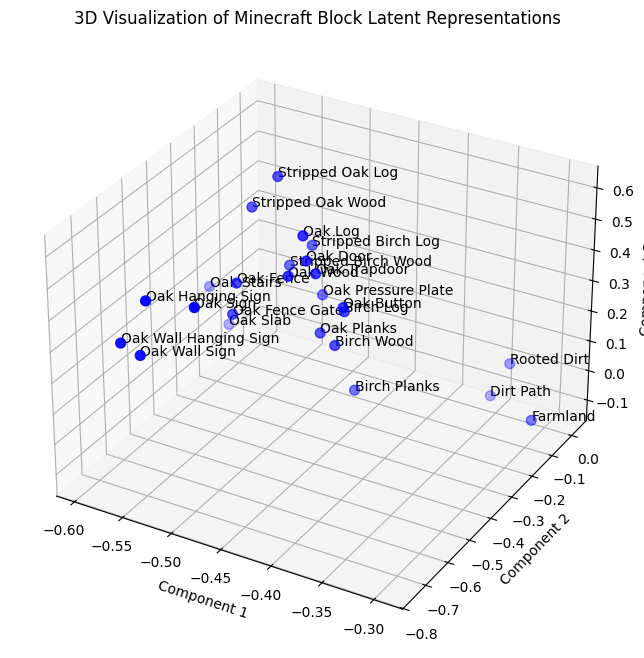

In [11]:
# Cell: Visualize latent representations in 3D space
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Reduce latent vectors to 3D using PCA
pca_3d = PCA(n_components=3)
latent_vectors_3d = pca_3d.fit_transform(latent_vectors)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

start = 100
stop = 125

# Scatter plot of latent vectors
ax.scatter(latent_vectors_3d[start:stop, 0], latent_vectors_3d[start:stop, 1], latent_vectors_3d[start:stop, 2], c='b', s=50)

# Annotate each point with its block name
for i, block in enumerate(block_names[start:stop]):
    ax.text(latent_vectors_3d[start+i, 0], latent_vectors_3d[start+i, 1], latent_vectors_3d[start+i, 2], block, size=10, zorder=1, color='black')

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.title("3D Visualization of Minecraft Block Latent Representations")
plt.show()

Hard to get 32 channels into a good 3 channel representation.